In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pandas as pd

from ex_biology import p
from dset import get_dataloader, load_pretrained_model

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform1d import DWT1d
from utils import get_1dfilts, get_wavefun
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_1dreconstruct, plot_wavefun

# evaluation
from eval_biology import load_results, max_transformer
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import time
sys.path.append('../../lib/trim')
from trim import TrimModel
from utils import tuple_to_tensor, tensor_to_tuple

# load results

In [2]:
dirs = [
        "db5_saliency_warmstart_seed=1"
        ]
dics, results, models = load_results(dirs)

# prediction accuracy, compression, and computation time

In [3]:
r = {
    'Standard Wavelet (DB5)': [],
    'AWD (Ours)': [],    
}

best_lam = []
best_wt = []

# params for feature transformer
sgn = "pos"
m = 6

index = 0
res = results[index]
mos = models[index]    

# load data
(train_loader, test_loader) = get_dataloader(p.data_path, 
                                             batch_size=p.batch_size,
                                             is_continuous=True)       


# cross validation
reg_score = []    

for i,wt in enumerate(list(dics[index]['wt'].values())):
    wt = wt.to('cpu')
    (X, y), (X_test, y_test) = max_transformer(wt, 
                                               train_loader, 
                                               test_loader,
                                               sgn=sgn,
                                               m=m)


    clf = LinearRegression()
    scores = cross_val_score(clf, X, y, cv=5, scoring='r2')
    reg_score.append(scores.mean())
reg_score = np.array(reg_score)    

# select best wavelet
idx1, idx2 = list(dics[index]['wt'].keys())[np.argmax(reg_score).flatten()[0]]
idx = dics[index]['index'][(idx1, idx2)]
lamL1wave = dics[index]['lamL1wave'][(idx1, idx2)]
lamL1attr = dics[index]['lamL1attr'][(idx1, idx2)]
best_lam.append((lamL1wave, lamL1attr))
wt = dics[index]['wt'][(idx1, idx2)]
best_wt.append(wt)

# load pre-trained model
model = load_pretrained_model(p.model_path, device=device)   

p.batch_size = 3000
(train_loader, test_loader) = get_dataloader(p.data_path, 
                                             batch_size=p.batch_size,
                                             is_continuous=True)   

(X, y), (X_test, y_test) = max_transformer(wt, 
                                           train_loader, 
                                           test_loader,
                                           sgn=sgn,
                                           m=m)

clf = LinearRegression().fit(X, y)
preds = clf.predict(X_test)
r['AWD (Ours)'].append(metrics.r2_score(y_test, preds))


wt_o = DWT1d(wave='db5', mode='zero', J=4, init_factor=1, noise_factor=0.0)
(X, y), (X_test, y_test) = max_transformer(wt_o, 
                                           train_loader, 
                                           test_loader,
                                           sgn=sgn,
                                           m=m)

clf_o = LinearRegression().fit(X, y)
preds = clf_o.predict(X_test)
r['Standard Wavelet (DB5)'].append(metrics.r2_score(y_test, preds))

print(r)

{'Standard Wavelet (DB5)': [0.19740176477695281], 'AWD (Ours)': [0.2625306384308951]}


In [4]:
X.shape

(2936, 30)

In [5]:
from eval_biology import get_tensors, max_fun

In [6]:
(train_loader, test_loader) = get_dataloader(p.data_path, 
                                             batch_size=p.batch_size,
                                             is_continuous=True)   

(X, y), (X_test, y_test) = max_transformer(wt, 
                                           train_loader, 
                                           test_loader,
                                           sgn=sgn,
                                           m=m)

clf = LinearRegression().fit(X, y)
preds = clf.predict(X_test)
print(metrics.r2_score(y_test, preds))

0.2625306384308951


In [37]:
wt = best_wt[0]
wt = wt.to('cpu')
J = wt.J

# h0 = wt.h0
# wt = DWT1d(wave='db5', mode='per', J=5).to('cpu')
# wt.h0 = h0

(Xs, y) = get_tensors(train_loader)
data_t = wt(Xs)
data_to = wt_o(Xs)

X = []
for j in range(J+1):
    d = data_t[j].detach().squeeze().numpy()
    X.append(max_fun(d, sgn=sgn, m=m))
X = np.hstack(X)
y = y.detach().squeeze().numpy()

idx = np.argsort(y)[::-1][50]
idx = 149

In [97]:
def helper(wc: tuple, scale, nums):
    """ 
    Threshold attributions retaining those with top absolute attributions 
    """    
    wc = list(wc)
    batch_size = wc[0].shape[0]
    J = len(wc)
   
    for j in range(J):
        if j != scale: 
            wc[j] = torch.zeros_like(wc[j])
        else:
            b = wc[j].reshape(batch_size, -1)
    sort_indexes = torch.argsort(b, dim=1, descending=True)      
    
    m = torch.zeros_like(sort_indexes)
    for i in range(batch_size):
        for num in nums:
            m[i][sort_indexes[i,num]] = 1
        
    wc[scale] = torch.mul(m.reshape(wc[scale].shape), wc[scale])
    return wc

In [104]:
idx_pos = np.argwhere(X[idx] * clf.coef_ > 0).squeeze()
idx_scale = []
for j in range(J+1):
    r = [i-6*j for i in idx_pos if 6*j <= i < 6*(j+1)]
    idx_scale.append(r)

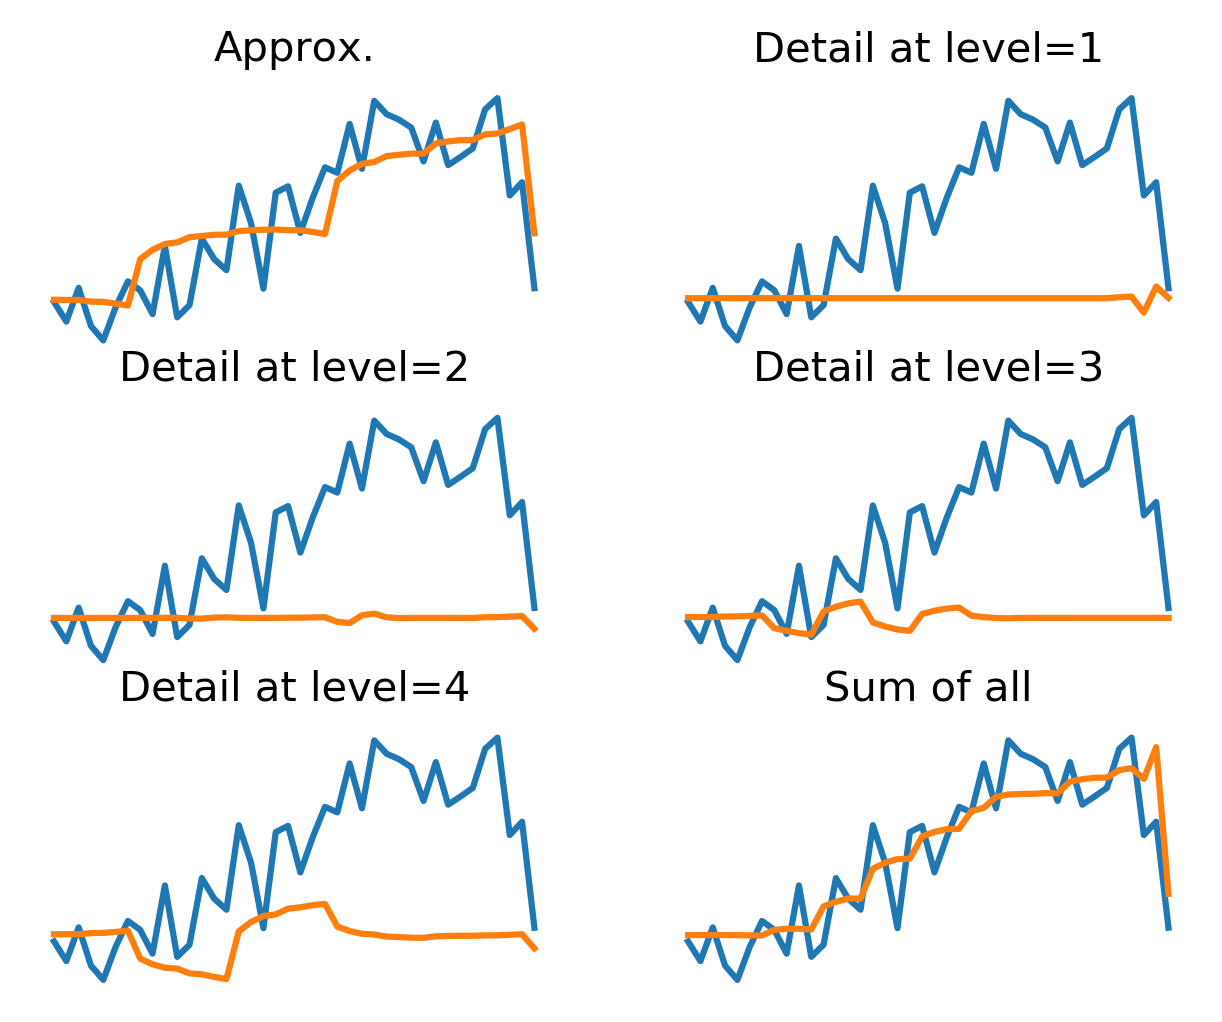

In [123]:
# plot
num_rows = 3
num_cols = 2
labels = ['Approx.', 'Detail at level=1', 'Detail at level=2', 'Detail at level=3', 'Detail at level=4', 'Sum of all']

fig = plt.figure(dpi=300, figsize=(5,4))
x = Xs[idx,0].squeeze().detach().numpy()
x_rs = []

for i in range(6):
    # distance plot
    plt.subplot(num_rows, num_cols, i + 1)
    
    if i <= 4:
        dt = helper(data_t, i, idx_scale[i])
        x_r = wt.inverse(dt)[idx,0].squeeze().detach().numpy()    
        plt.plot(x)
        plt.plot(x_r)
        x_rs.append(x_r)
        
    if i == 5:
        x_r = 0
        for a in x_rs:
            x_r += a
        plt.plot(x)
        plt.plot(x_r)
        
    plt.title(labels[i], fontsize=10)
    plt.axis('off')
    

    
#     for r in range(R):
#         d_array = [dics[i]['dist'][(r,c)] for c in range(C)]
#         plt.plot(np.log(lamL1attr_grid[1:]), d_array[1:], label='$\lambda=$'+str(lamL1wave_grid[r]))
#     plt.xlabel('$\log(\gamma)$')
#     if i == 0:
#         plt.ylabel('distance')    
#     plt.legend(loc='upper right')  
#     plt.title(labels[i])